In [2]:
import os

import networkx as nx
import numpy as np

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from tqdm import tqdm, trange

In [3]:
SAVE_RES_DIR = "./matrices_viz/closed_data"

if not os.path.exists(SAVE_RES_DIR):
    os.makedirs(SAVE_RES_DIR)

In [4]:
MATRICES_PATH = "./matrices_new/relevant_matrices_closed_data/"
MATRICES_FILES = [el for el in os.listdir(MATRICES_PATH) if el.endswith(".csv")]
MATRICES_FILES

['bert__similarity_scores.csv',
 'bioclinical_bert.csv',
 'co_matrix_counts.csv',
 'fisher_closed_real_data.csv',
 'genes_graph_paper_2007.csv',
 'gpt_oss.csv',
 'mlm_results.csv',
 'scores_DeepSeek-V3_mean.csv',
 'scores_medbert.csv',
 'scores_qwen3-235b-a22b_0.csv',
 'yandex_doc_search__scores_llm_doc.csv',
 'yandex_gpt_5__yandex_prompt_matrix.csv']

In [5]:
common_columns, common_rows = [], []
all_dfs = dict()

for m_file in tqdm(MATRICES_FILES):
    if "gene" not in m_file:
        # if "fisher" in m_file:
        #     sep = ";"
        # else:
        #     sep = ","
        sep = ","
        df = pd.read_csv(os.path.join(MATRICES_PATH, m_file), sep=sep)
        if "Unnamed: 0" in df.columns:
            df = df.set_index("Unnamed: 0")
        print(m_file, df.shape)
        all_dfs[m_file] = df
        common_columns.append(df.columns.tolist())
        common_rows.append(df.index.tolist())

common_columns = set.intersection(*map(set, common_columns))
common_rows = set.intersection(*map(set, common_rows))

len(common_columns), len(common_rows)

  8%|▊         | 1/12 [00:00<00:03,  3.33it/s]

bert__similarity_scores.csv (1696, 1696)


 17%|█▋        | 2/12 [00:00<00:02,  3.38it/s]

bioclinical_bert.csv (1704, 1704)
co_matrix_counts.csv (879, 879)
fisher_closed_real_data.csv (879, 879)


 50%|█████     | 6/12 [00:01<00:00,  6.65it/s]

gpt_oss.csv (2101, 2101)
mlm_results.csv (860, 860)


 67%|██████▋   | 8/12 [00:01<00:00,  5.81it/s]

scores_DeepSeek-V3_mean.csv (2046, 2046)


 75%|███████▌  | 9/12 [00:01<00:00,  5.01it/s]

scores_medbert.csv (1757, 1757)


 83%|████████▎ | 10/12 [00:01<00:00,  4.79it/s]

scores_qwen3-235b-a22b_0.csv (2032, 2032)


100%|██████████| 12/12 [00:02<00:00,  4.59it/s]

yandex_doc_search__scores_llm_doc.csv (1696, 1696)
yandex_gpt_5__yandex_prompt_matrix.csv (1696, 1696)


(818, 818)

In [6]:
assert len(all_dfs) == len(MATRICES_FILES) - 1, "Probably gene-based GT is in all_dfs!!!"

In [7]:
common_icds = sorted(list(common_columns & common_rows))
len(common_icds)

818

In [8]:
for df_name, df in tqdm(all_dfs.items()):
    df1 = deepcopy(df)
    df1 = df1[common_icds][df1.index.isin(common_icds)].reindex(common_icds)
    np.fill_diagonal(df1.values, 0)
    all_dfs[df_name] = df1

100%|██████████| 11/11 [00:00<00:00, 100.43it/s]


In [9]:
for df_name, df in tqdm(all_dfs.items()):
    print(df.shape)

100%|██████████| 11/11 [00:00<00:00, 3020.45it/s]

(818, 818)
(818, 818)
(818, 818)
(818, 818)
(818, 818)
(818, 818)
(818, 818)
(818, 818)
(818, 818)
(818, 818)
(818, 818)


In [11]:
EXPERIMENTS = {
    "Methods on real data": {
        "Fisher exact test": 'fisher_closed_real_data.csv',
        "Jaccard similarity": 'co_matrix_counts.csv',
        "MLM": 'mlm_results.csv',
    },
    "Pretrained on medical domain": {
        "Med-BERT": 'scores_medbert.csv',
        "BioClinicalBERT": 'bioclinical_bert.csv',
    },
    "Text-based methods": {
        "Pretrained BERT": 'bert__similarity_scores.csv', 
        "Yandex Doc Search": 'yandex_doc_search__scores_llm_doc.csv', 
    },
    "LLMs": {
        "GPT-OSS": "gpt_oss.csv",
        "Qwen-3": 'scores_qwen3-235b-a22b_0.csv',
        "DeepSeek-v3": 'scores_DeepSeek-V3_mean.csv',
        "YandexGPT-5": 'yandex_gpt_5__yandex_prompt_matrix.csv',
    }
}

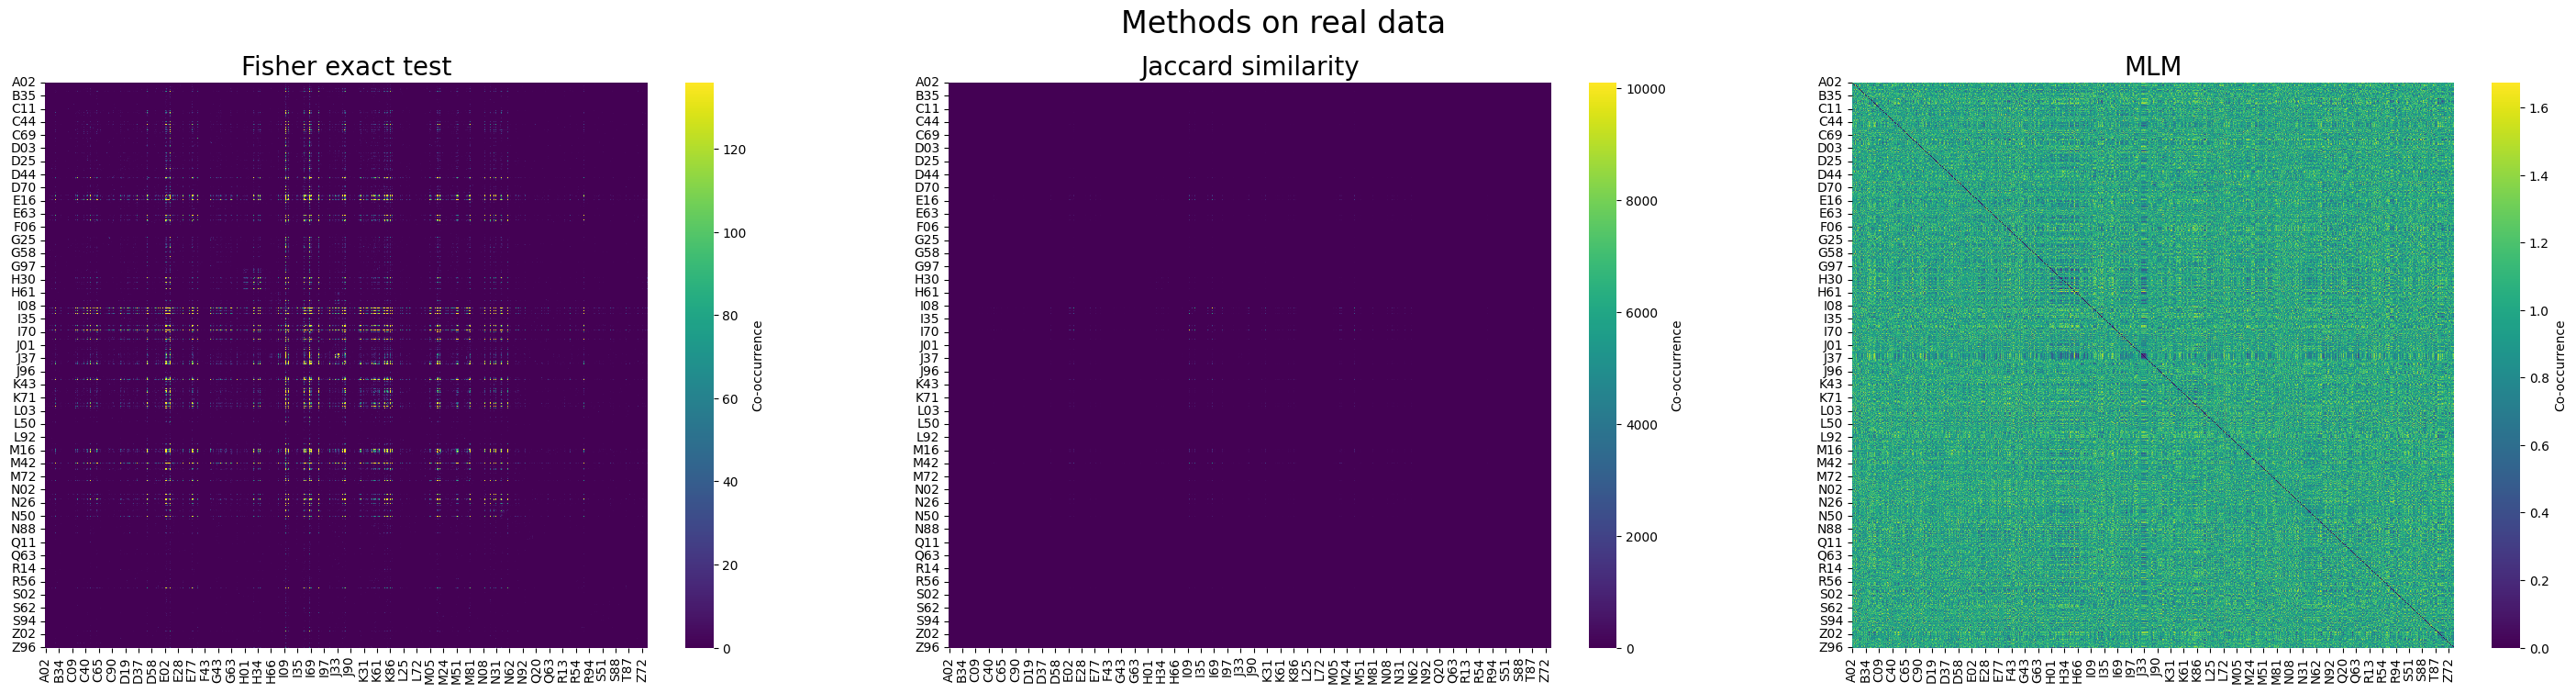

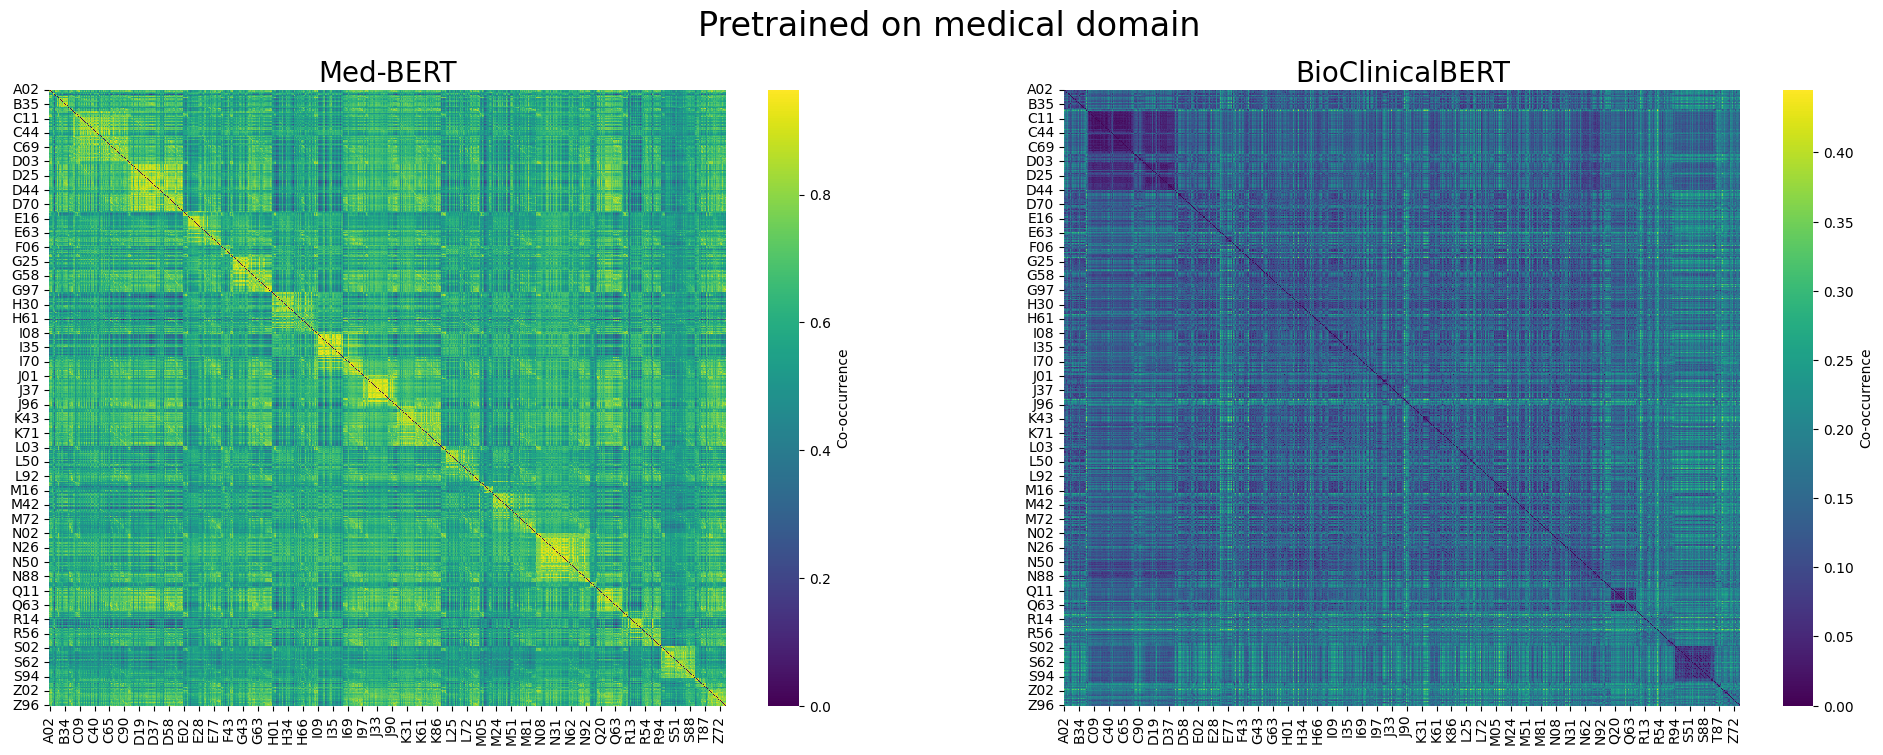

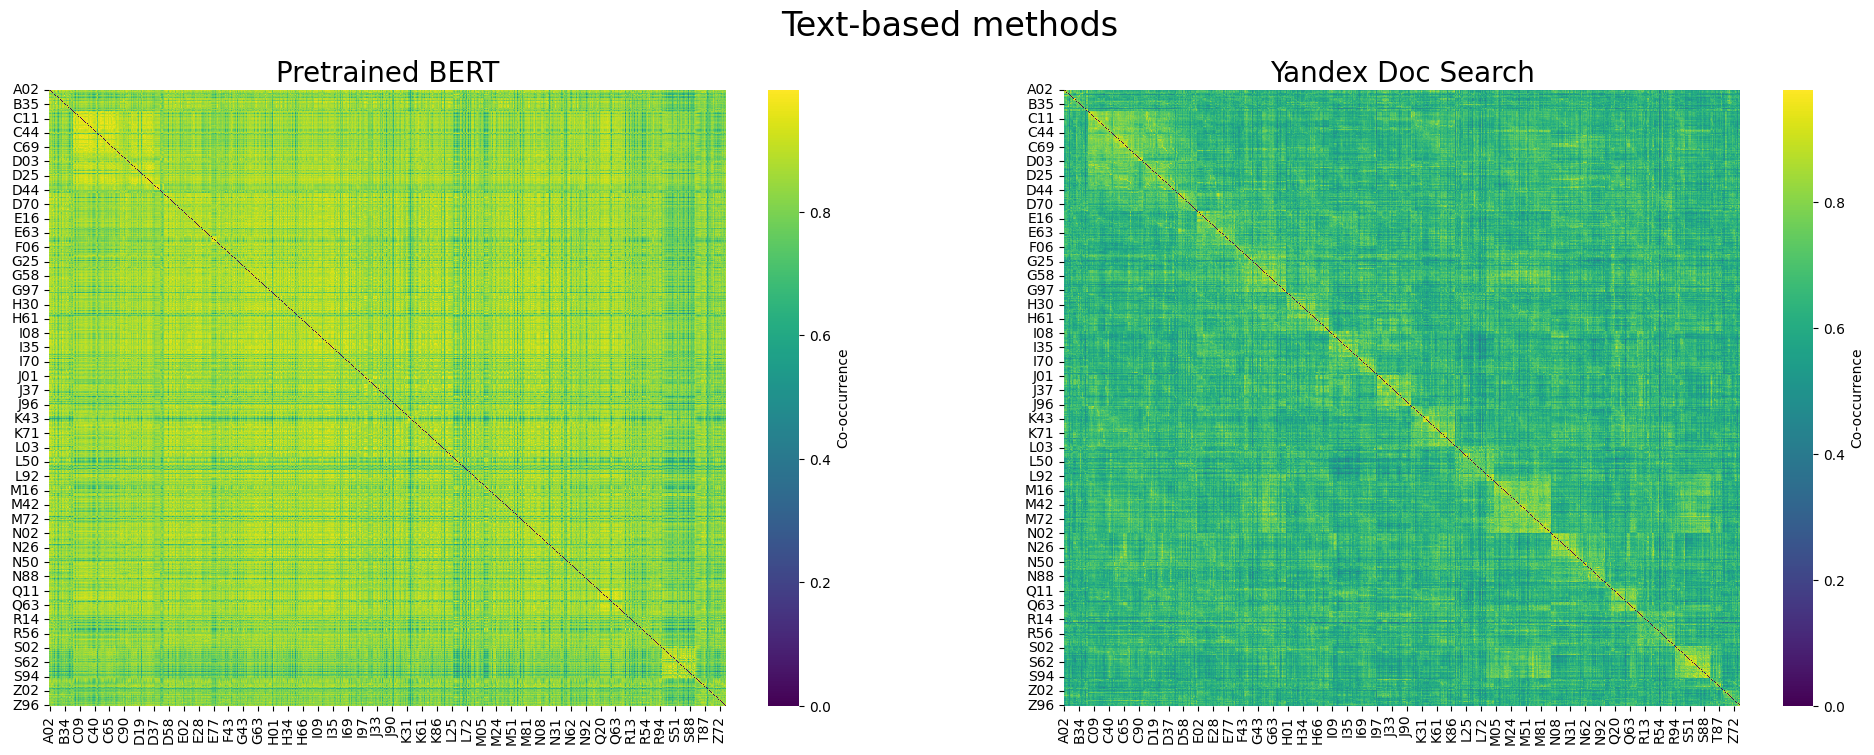

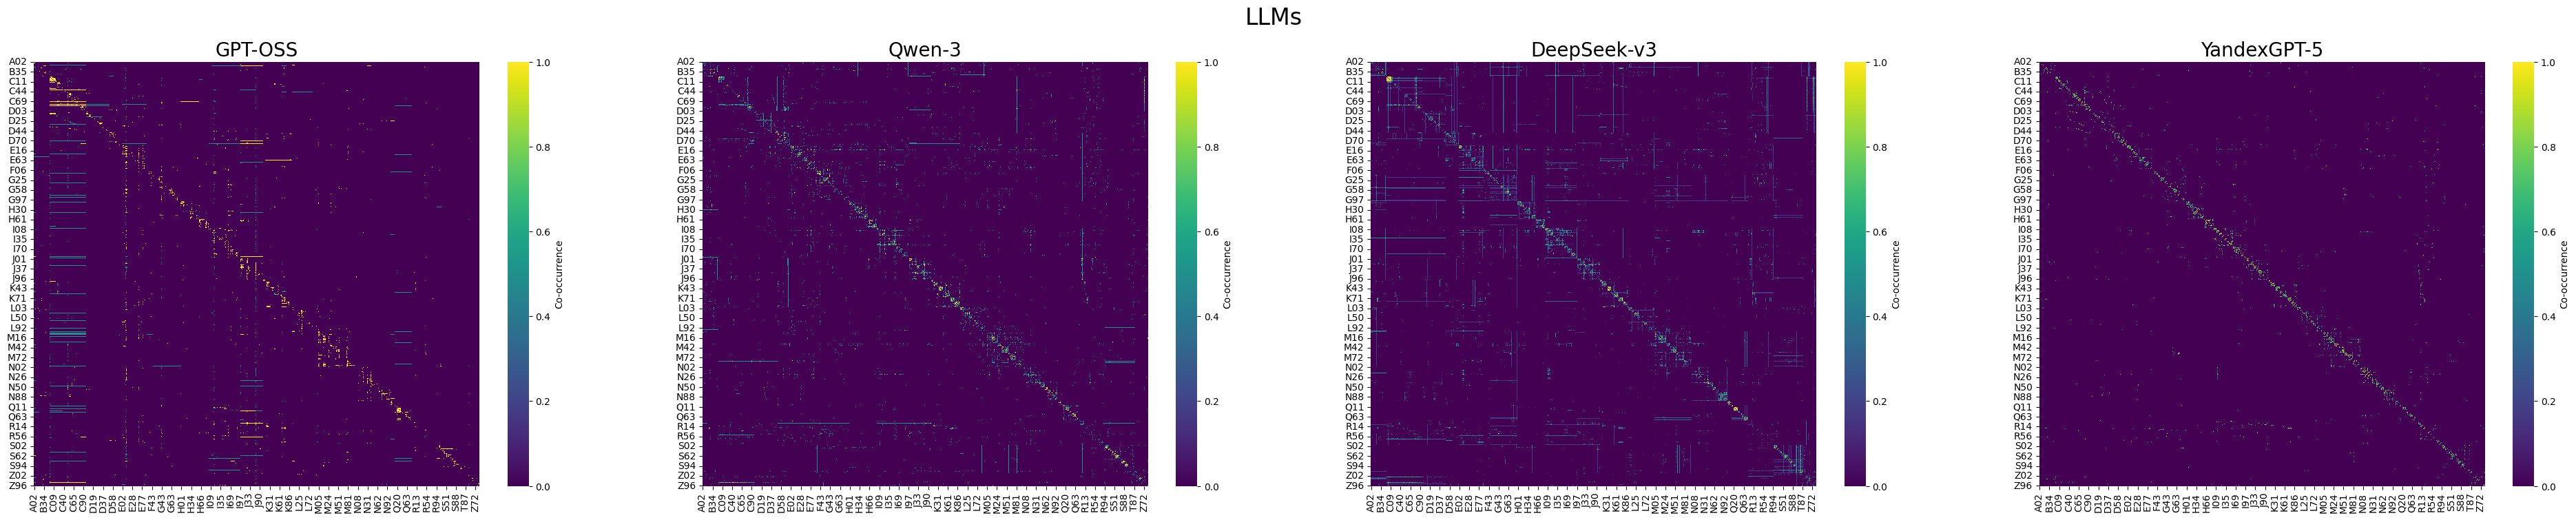

In [12]:
for exp_cat, exp_files in EXPERIMENTS.items():
    ncols = len(exp_files.values())
    fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(12*ncols, 8))
    fig.suptitle(exp_cat, fontsize=24)
    for i, (model_name, m_file) in enumerate(exp_files.items()):
        axes = ax if ncols == 1 else ax[i]
        df = all_dfs[m_file]
        if "fisher" in m_file:
            upper_bound = np.quantile(df.values.reshape(-1), 0.997) #np.quantile(df.values, 0.75)
            df[df > upper_bound] = upper_bound

        sns.heatmap(
            df,
            cmap="viridis",
            cbar_kws={"label": "Co-occurrence"},
            ax=axes,
        )
        axes.set_xlabel("");
        axes.set_ylabel("");
        axes.set_title(model_name, fontsize=20);
    plt.savefig(
        f"{SAVE_RES_DIR}/{exp_cat.lower().replace(' ', '_')}.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

# Correlation analysis

In [13]:
EXPERIMENTS_unfold = dict()
for k, v in EXPERIMENTS.items():
    for model_name, m_file in v.items():
        EXPERIMENTS_unfold[model_name] = m_file
EXPERIMENTS_unfold

{'Fisher exact test': 'fisher_closed_real_data.csv',
 'Jaccard similarity': 'co_matrix_counts.csv',
 'MLM': 'mlm_results.csv',
 'Med-BERT': 'scores_medbert.csv',
 'BioClinicalBERT': 'bioclinical_bert.csv',
 'Pretrained BERT': 'bert__similarity_scores.csv',
 'Yandex Doc Search': 'yandex_doc_search__scores_llm_doc.csv',
 'GPT-OSS': 'gpt_oss.csv',
 'Qwen-3': 'scores_qwen3-235b-a22b_0.csv',
 'DeepSeek-v3': 'scores_DeepSeek-V3_mean.csv',
 'YandexGPT-5': 'yandex_gpt_5__yandex_prompt_matrix.csv'}

In [14]:
list(EXPERIMENTS_unfold.keys())

['Fisher exact test',
 'Jaccard similarity',
 'MLM',
 'Med-BERT',
 'BioClinicalBERT',
 'Pretrained BERT',
 'Yandex Doc Search',
 'GPT-OSS',
 'Qwen-3',
 'DeepSeek-v3',
 'YandexGPT-5']

In [15]:
from scipy.stats import spearmanr

In [16]:
corrs = []
for i, (model_name_i, m_file_i) in tqdm(enumerate(EXPERIMENTS_unfold.items())):
    for j, (model_name_j, m_file_j) in enumerate(EXPERIMENTS_unfold.items()):
        if model_name_i != model_name_j:
            df_i, df_j = all_dfs[m_file_i], all_dfs[m_file_j]
            corr, pval = spearmanr(
                df_i.values.flatten(),
                df_j.values.flatten(),
            )
            corrs.append(
                {
                    "model_i": model_name_i,
                    "model_j": model_name_j,
                    "corr_coef": corr,
                    "p_val": pval,

                }
            )

corrs = pd.DataFrame(corrs)
corrs

11it [00:14,  1.28s/it]


model_i             model_j  corr_coef          p_val
0    Fisher exact test  Jaccard similarity   0.883695   0.000000e+00
1    Fisher exact test                 MLM  -0.009259   3.619114e-14
2    Fisher exact test            Med-BERT   0.006075   6.725202e-07
3    Fisher exact test     BioClinicalBERT  -0.083404   0.000000e+00
4    Fisher exact test     Pretrained BERT   0.050872   0.000000e+00
..                 ...                 ...        ...            ...
105        YandexGPT-5     Pretrained BERT   0.039364  1.199459e-227
106        YandexGPT-5   Yandex Doc Search   0.107638   0.000000e+00
107        YandexGPT-5             GPT-OSS   0.118591   0.000000e+00
108        YandexGPT-5              Qwen-3   0.258198   0.000000e+00
109        YandexGPT-5         DeepSeek-v3   0.226864   0.000000e+00

[110 rows x 4 columns]

In [17]:
np.unique(corrs["p_val"])

array([0.00000000e+000, 1.19945853e-227, 3.14604265e-207, 1.15131406e-206,
       1.52929327e-203, 1.52929327e-203, 1.53946538e-188, 5.50016397e-183,
       1.59173632e-152, 1.59173632e-152, 6.27612666e-149, 6.27612666e-149,
       3.22025279e-144, 3.64644848e-134, 3.96231373e-064, 1.48382481e-058,
       3.52603272e-053, 8.68298593e-041, 2.87467029e-023, 2.87467029e-023,
       4.62076044e-016, 3.61911433e-014, 1.12165084e-010, 6.72520193e-007,
       1.43850691e-006, 1.43850691e-006, 1.57244859e-006, 5.47202486e-003,
       5.92613818e-002, 1.30125437e-001, 5.12268638e-001])

In [18]:
corrs['model_i'] = pd.Categorical(
    corrs['model_i'], 
    categories=list(EXPERIMENTS_unfold.keys()), 
    ordered=True,
)
corrs['model_j'] = pd.Categorical(
    corrs['model_j'], 
    categories=list(EXPERIMENTS_unfold.keys()), 
    ordered=True,
)

In [19]:
corrs_matrix = corrs.pivot(index="model_i", columns="model_j", values="corr_coef").fillna(1).round(3)
corrs_matrix

model_j             Fisher exact test  Jaccard similarity    MLM  Med-BERT  \
model_i                                                                      
Fisher exact test               1.000               0.884 -0.009     0.006   
Jaccard similarity              0.884               1.000 -0.012     0.010   
MLM                            -0.009              -0.012  1.000     0.002   
Med-BERT                        0.006               0.010  0.002     1.000   
BioClinicalBERT                -0.083              -0.089  0.019    -0.082   
Pretrained BERT                 0.051               0.055 -0.006     0.130   
Yandex Doc Search               0.016               0.021  0.002     0.221   
GPT-OSS                         0.030               0.032 -0.003     0.032   
Qwen-3                          0.054               0.059 -0.008     0.058   
DeepSeek-v3                     0.031               0.035 -0.001     0.080   
YandexGPT-5                     0.051               0.058 -0.006     0.070   

model_j             BioClinicalBERT  Pretrained BERT  Yandex Doc Search  \
model_i                                                                   
Fisher exact test            -0.083            0.051              0.016   
Jaccard similarity           -0.089            0.055              0.021   
MLM                           0.019           -0.006              0.002   
Med-BERT                     -0.082            0.130              0.221   
BioClinicalBERT               1.000           -0.404             -0.219   
Pretrained BERT              -0.404            1.000              0.260   
Yandex Doc Search            -0.219            0.260              1.000   
GPT-OSS                      -0.038            0.020              0.047   
Qwen-3                       -0.037            0.037              0.119   
DeepSeek-v3                  -0.054            0.036              0.160   
YandexGPT-5                  -0.053            0.039              0.108   

model_j             GPT-OSS  Qwen-3  DeepSeek-v3  YandexGPT-5  
model_i                                                        
Fisher exact test     0.030   0.054        0.031        0.051  
Jaccard similarity    0.032   0.059        0.035        0.058  
MLM                  -0.003  -0.008       -0.001       -0.006  
Med-BERT              0.032   0.058        0.080        0.070  
BioClinicalBERT      -0.038  -0.037       -0.054       -0.053  
Pretrained BERT       0.020   0.037        0.036        0.039  
Yandex Doc Search     0.047   0.119        0.160        0.108  
GPT-OSS               1.000   0.139        0.108        0.119  
Qwen-3                0.139   1.000        0.289        0.258  
DeepSeek-v3           0.108   0.289        1.000        0.227  
YandexGPT-5           0.119   0.258        0.227        1.000

In [20]:
SAVE_RES_DIR

'./matrices_viz/closed_data'

In [21]:
# !pip install openpyxl

In [22]:
corrs_matrix.to_excel(f"{SAVE_RES_DIR}/corrs_matrix.xlsx")

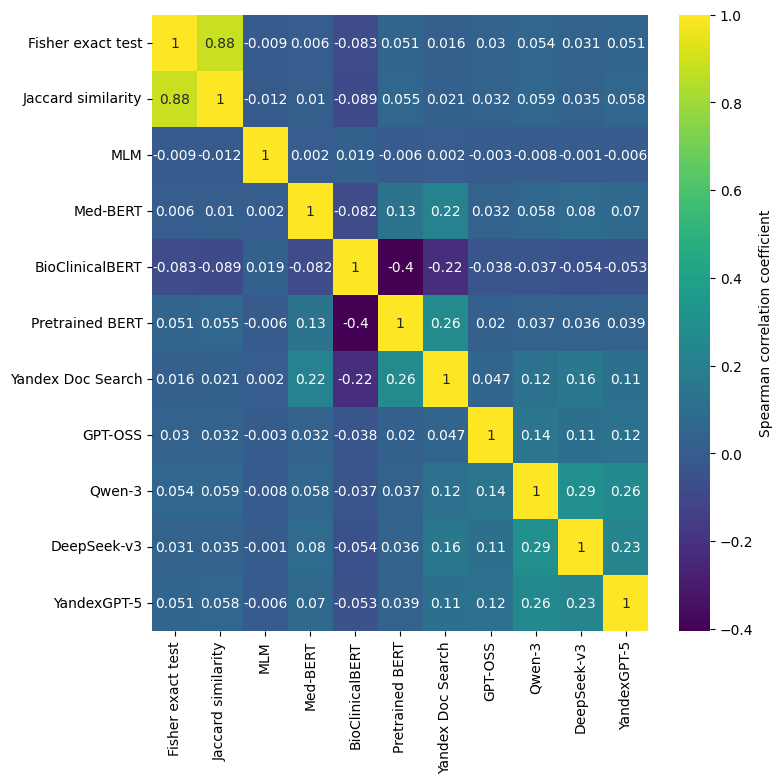

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

sns.heatmap(
    data=corrs_matrix,
    cmap="viridis",
    cbar_kws={"label": "Spearman correlation coefficient"},
    annot=True,
    ax=ax,
)
ax.set_xlabel("");
ax.set_ylabel("");

plt.savefig(
    f"{SAVE_RES_DIR}/spearman_corr.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [24]:
for col in corrs_matrix:
    print(
        col,
        round(corrs_matrix[col].min(), 3),
        round(corrs_matrix[col][corrs_matrix[col] != 1].max(), 3),
    )

Fisher exact test -0.083 0.884
Jaccard similarity -0.089 0.884
MLM -0.012 0.019
Med-BERT -0.082 0.221
BioClinicalBERT -0.404 0.019
Pretrained BERT -0.404 0.26
Yandex Doc Search -0.219 0.26
GPT-OSS -0.038 0.139
Qwen-3 -0.037 0.289
DeepSeek-v3 -0.054 0.289
YandexGPT-5 -0.053 0.258
